In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/users/nchib/DS5/DS-Unit-2-Project/dash-app-template/notebooks/data/df_final1.csv')

In [3]:
df = df.drop(columns='Unnamed: 0')

In [4]:
print(df.shape)
df.head()

(102840, 2)


,label,text
0,1,RT @Papapishu: Man it would fucking rule if we...
1,2,It is time to draw close to Him &#128591;&#127...
2,2,if you notice me start to act different or dis...
3,2,"Forget unfollowers, I believe in growing. 7 ne..."
4,1,RT @Vitiligoprince: Hate Being sexually Frustr...


## Baseline - predict majority class


In [5]:
df['label'].value_counts(normalize=True)

2    0.558139
1    0.387904
0    0.053958
Name: label, dtype: float64

## Clean data


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re

In [7]:
# nltk.download('stopwords')

stopwords=pd.read_table("english").values.tolist()
stopwords=sum(stopwords , [])
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

In [8]:
tweets = df['text']

def clean(text):
    spaces = '\s+'
    urls = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mentions = '@[\w\-]+'
    parsed_text = re.sub(spaces, ' ', text)
    parsed_text = re.sub(urls, '', parsed_text)
    parsed_text = re.sub(mentions, '', parsed_text)
    return parsed_text

In [9]:
def tokenize(text):
    text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    tokens = [stemmer.stem(t) for t in text.split()]
    return tokens

In [10]:
def basic_tokenize(text):
    text = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [11]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=clean,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

In [12]:
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

C:\Users\nchib\.virtualenvs\dash-app-template-JUXX2GS7\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

sentiment_analyzer = VS()

def count_twitter_objs(text):
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    
    words = clean(text) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(text) #Count #, @, and http://
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [ ]:
feats = get_feature_array(tweets)

In [ ]:
all = np.concatenate([tfidf,feats],axis=1)

In [ ]:
all.shape

In [ ]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

feature_names = variables+other_features_names

In [ ]:
features = feature_names
target = 'label'
X = pd.DataFrame(all)
y = df['label'].astype(int)

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [ ]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X_trainval,y_trainval)

In [ ]:
model = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01).fit(X_, y_trainval)

In [ ]:
# from scipy.stats import randint, uniform
# from sklearn.model_selection import RandomizedSearchCV


# lr = LogisticRegression()
# params = {'penalty': ['l1', 'l2'], 'C':np.logspace(-5,0,100)}

# search = RandomizedSearchCV(
#     pipeline, 
#     param_distributions=param_distributions, 
#     n_iter=5, 
#     cv=2, 
#     scoring='neg_mean_squared_error', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_train, y_train_log, groups=groups);

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C':np.logspace(-5,0,100)}
#Grid searching to find optimal parameters for Logistic Regression
gs = GridSearchCV(lr, param_grid=params, cv=10, verbose=1)
gs.fit(X, y)

In [ ]:
y_pred = model.predict(X_)

In [ ]:
report = classification_report(y_trainval, y_pred)
print(report)

In [ ]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X_test,y_test)

In [ ]:
model = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01).fit(X_, y_test)

In [ ]:
y_pred = model.predict(X_)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

## Create pipeline

In [ ]:
def wrangle(text):
    
    nltk.download('stopwords')

    stopwords=stopwords = nltk.corpus.stopwords.words("english")

    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)

    stemmer = PorterStemmer()

    def clean(text):
        spaces = '\s+'
        urls = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mentions = '@[\w\-]+'
        parsed_text = re.sub(spaces, ' ', text)
        parsed_text = re.sub(urls, '', parsed_text)
        parsed_text = re.sub(mentions, '', parsed_text)
        return parsed_text
    
    def tokenize(text):
        text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
        tokens = [stemmer.stem(t) for t in text.split()]
        return tokens

        vectorizer = TfidfVectorizer(
        tokenizer=tokenize,
        preprocessor=clean,
        ngram_range=(1, 3),
        stop_words=stopwords,
        use_idf=True,
        smooth_idf=False,
        norm=None,
        decode_error='replace',
        max_features=10000,
        min_df=5,
        max_df=0.501
        )
    
    tfidf = vectorizer.fit_transform(text).toarray()
    vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
    idf_vals = vectorizer.idf_
    idf_dict = {i:idf_vals[i] for i in vocab.values()}
    
    sentiment_analyzer = VS()

    def count_twitter_objs(text):
    
        space_pattern = '\s+'
        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mention_regex = '@[\w\-]+'
        hashtag_regex = '#[\w\-]+'
        parsed_text = re.sub(space_pattern, ' ', text)
        parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
        parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
        parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
        return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

    def other_features(text):
        sentiment = sentiment_analyzer.polarity_scores(text)

        words = clean(text) #Get text only

        syllables = textstat.syllable_count(words) #count syllables in words
        num_chars = sum(len(w) for w in words) #num chars in words
        num_chars_total = len(text)
        num_terms = len(text.split())
        num_words = len(words.split())
        avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
        num_unique_terms = len(set(words.split()))

        FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)

        FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

        twitter_objs = count_twitter_objs(text) #Count #, @, and http://
        retweet = 0
        if "rt" in words:
            retweet = 1
        features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                    num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                    twitter_objs[2], twitter_objs[1],
                    twitter_objs[0], retweet]

        return features

    def get_feature_array(text):
        feats=[]
        for t in text:
            feats.append(other_features(t))
        return np.array(feats)
    
    feats = get_feature_array(text)
    
    all = np.concatenate([tfidf,feats],axis=1)
    
    other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

    variables = ['']*len(vocab)
    for k,v in vocab.items():
        variables[v] = k

    features = variables+other_features_names
    X = pd.DataFrame(all)
    
    
    return X
    
    

In [ ]:
tweets = df['text']
trial3 = wrangle(tweets)

In [ ]:
trial3

In [ ]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(trial2,df['label'])

In [ ]:
model = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01).fit(trial2, df['label'])
y_pred = model.predict(trial2)

In [ ]:
report = classification_report(df['label'], y_pred)
print(report)

In [ ]:
def wrangle2(text):
    
    nltk.download('stopwords')

    stopwords=stopwords = nltk.corpus.stopwords.words("english")

    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)
    
#     if type(text)==pd.DataFrame:
#         text = text['text']
#     if text(text)==list:
#         text = text

    stemmer = PorterStemmer()

    def clean(text):
        spaces = '\s+'
        urls = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mentions = '@[\w\-]+'
        parsed_text = re.sub(spaces, ' ', text)
        parsed_text = re.sub(urls, '', parsed_text)
        parsed_text = re.sub(mentions, '', parsed_text)
        return parsed_text
    
    def tokenize(text):
        text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
        tokens = [stemmer.stem(t) for t in text.split()]
        return tokens

        vectorizer = TfidfVectorizer(
        tokenizer=tokenize,
        preprocessor=clean,
        ngram_range=(1, 3),
        stop_words=stopwords,
        use_idf=True,
        smooth_idf=False,
        norm=None,
        decode_error='replace',
        max_features=10000,
        min_df=5,
        max_df=0.501
        )
    
    tfidf = vectorizer.transform(text).toarray()
    vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
    idf_vals = vectorizer.idf_
    idf_dict = {i:idf_vals[i] for i in vocab.values()}
    
    sentiment_analyzer = VS()

    def count_twitter_objs(text):
    
        space_pattern = '\s+'
        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mention_regex = '@[\w\-]+'
        hashtag_regex = '#[\w\-]+'
        parsed_text = re.sub(space_pattern, ' ', text)
        parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
        parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
        parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
        return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

    def other_features(text):
        sentiment = sentiment_analyzer.polarity_scores(text)

        words = clean(text) #Get text only

        syllables = textstat.syllable_count(words) #count syllables in words
        num_chars = sum(len(w) for w in words) #num chars in words
        num_chars_total = len(text)
        num_terms = len(text.split())
        num_words = len(words.split())
        avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
        num_unique_terms = len(set(words.split()))

        FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)

        FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

        twitter_objs = count_twitter_objs(text) #Count #, @, and http://
        retweet = 0
        if "rt" in words:
            retweet = 1
        features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                    num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                    twitter_objs[2], twitter_objs[1],
                    twitter_objs[0], retweet]

        return features

    def get_feature_array(text):
        feats=[]
        for t in text:
            feats.append(other_features(t))
        return np.array(feats)
    
    feats = get_feature_array(text)
    
    all = np.concatenate([tfidf,feats],axis=1)
    
    other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

    variables = ['']*len(vocab)
    for k,v in vocab.items():
        variables[v] = k

    features = variables+other_features_names
    X = pd.DataFrame(all)
    
    
    return X

In [ ]:
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!"
]

Xtest = wrangle2(source_test)

In [ ]:
# select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01)
# X_ = select.transform(X_trainval,y_trainval)

y_predtest = model.predict(Xtest)
pd.DataFrame(model.predict_proba(Xtest), columns=["Hateful", "Offensive", "Normal"])

In [ ]:
test_two = ["So Drasko just said he was impressed the girls cooked half a chicken.. They cooked a whole one  #MKR"]
Xtest2 = wrangle2(test_two)

In [ ]:
y_predtest = model.predict(Xtest2)
pd.DataFrame(model.predict_proba(Xtest2), columns=["Hateful", "Offensive", "Normal"])

In [ ]:
y_predtest

In [ ]:
# estimator = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01)
# select = SelectFromModel(estimator)
# X_ = select.transform(X_trainval,y_trainval)
# estimator.fit(X_,y_trainval)

# pd.DataFrame(estimator.predict_proba(Xtest), columns=["Hateful", "Offensive", "Normal"])

In [20]:
from sklearn.pipeline import make_pipeline

target = 'label'
X = pd.DataFrame(all)
y = df['label'].astype(int)

model = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01)

model.fit(X,y)

C:\Users\nchib\.virtualenvs\dash-app-template-JUXX2GS7\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nchib\.virtualenvs\dash-app-template-JUXX2GS7\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [26]:
all.shape

(102840, 5467)

In [69]:
y_pred = model.predict(X_trainval)

In [70]:
report = classification_report(y_trainval, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      4470
           1       0.88      0.84      0.86     32134
           2       0.90      0.93      0.92     46236

   micro avg       0.86      0.86      0.86     82840
   macro avg       0.70      0.70      0.70     82840
weighted avg       0.86      0.86      0.86     82840



In [24]:
from joblib import dump
# dump(pipeline, 'pipeline.joblib')

In [25]:
dump(model, 'model.joblib')

['model.joblib']

In [51]:
dump(report, 'report.joblib')

['report.joblib']

In [73]:
%matplotlib inline
import sklearn
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [74]:
sklearn.metrics.confusion_matrix(y_trainval, y_pred)

array([[ 1463,  1462,  1545],
       [ 1962, 26903,  3269],
       [ 1038,  2082, 43116]], dtype=int64)

In [81]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

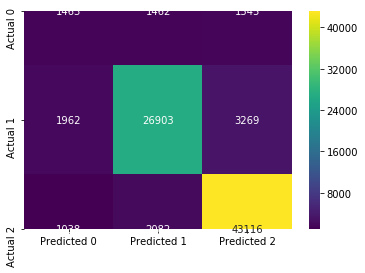

In [84]:
plot_confusion_matrix(y_trainval, y_pred);

In [87]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_trainval, y_trainval)
feature_names = features
eli5.show_weights(permuter, top=None, feature_names=features)

KeyboardInterrupt: 

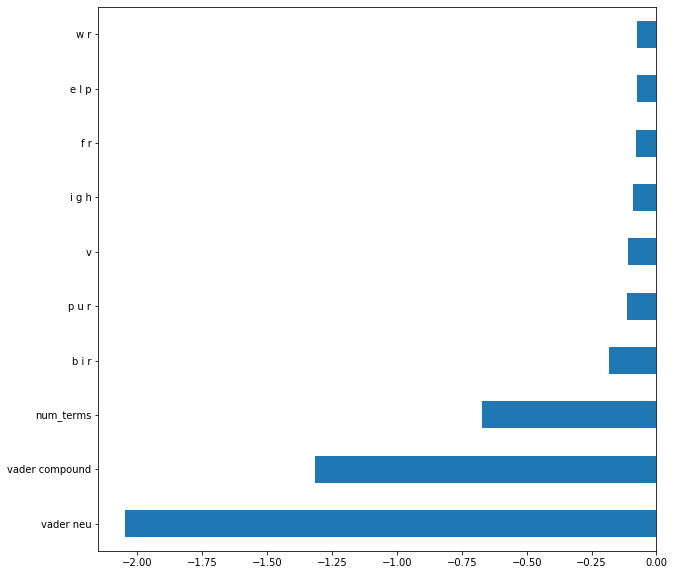

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

coefficients = pd.Series(model.coef_[0], features)
coefficients.sort_values(ascending=False).nsmallest(10).plot.barh();

In [183]:
from sklearn.feature_extraction.text import CountVectorizer

In [228]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if word not in stopwords]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [229]:
corpus_h = df.text[df['label'] == 0].tolist()
corpus_o = df.text[df['label'] == 1].tolist()
corpus_n = df.text[df['label'] == 2].tolist()

In [230]:
get_top_n_words(corpus_h, n=30)

[('co', 2023),
 ('https', 1920),
 ('hate', 679),
 ('like', 591),
 ('nigga', 571),
 ('fucking', 552),
 ('128514', 483),
 ('niggas', 439),
 ('bitch', 362),
 ('ass', 346),
 ('people', 340),
 ('get', 328),
 ('amp', 310),
 ('trump', 260),
 ('idiot', 242),
 ('fuck', 233),
 ('faggot', 197),
 ('white', 193),
 ('know', 192),
 ('one', 181),
 ('stupid', 176),
 ('want', 167),
 ('bad', 164),
 ('ugly', 153),
 ('say', 153),
 ('think', 152),
 ('hell', 151),
 ('got', 149),
 ('bitches', 148),
 ('go', 147)]

In [231]:
get_top_n_words(corpus_o, n=30)

[('co', 11293),
 ('fucking', 10539),
 ('https', 9599),
 ('bitch', 9424),
 ('128514', 5031),
 ('like', 4128),
 ('bitches', 3495),
 ('ass', 3063),
 ('fucked', 3036),
 ('fuck', 2727),
 ('hoes', 2415),
 ('pussy', 2405),
 ('get', 2350),
 ('shit', 2089),
 ('hoe', 1982),
 ('http', 1831),
 ('got', 1824),
 ('8220', 1479),
 ('8221', 1432),
 ('bad', 1387),
 ('know', 1377),
 ('amp', 1372),
 ('nigga', 1311),
 ('hate', 1283),
 ('one', 1151),
 ('128557', 1150),
 ('want', 1063),
 ('go', 1063),
 ('people', 1060),
 ('lol', 981)]

In [234]:
get_top_n_words(corpus_n, n=30)

[('co', 40690),
 ('https', 39674),
 ('amp', 3807),
 ('like', 3343),
 ('one', 2830),
 ('get', 2488),
 ('people', 2252),
 ('new', 2052),
 ('love', 1993),
 ('time', 1967),
 ('know', 1861),
 ('today', 1816),
 ('day', 1774),
 ('see', 1573),
 ('good', 1559),
 ('128514', 1527),
 ('would', 1507),
 ('us', 1485),
 ('via', 1483),
 ('want', 1385),
 ('go', 1331),
 ('great', 1280),
 ('make', 1275),
 ('think', 1243),
 ('back', 1240),
 ('trump', 1184),
 ('really', 1180),
 ('need', 1142),
 ('much', 1138),
 ('got', 1121)]

In [246]:
y_pred == y_trainval

74615     True
25872     True
7837      True
26749     True
37009    False
         ...  
32551    False
6378      True
45317     True
14401     True
63758     True
Name: label, Length: 82840, dtype: bool

In [250]:
report = classification_report(y_trainval, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      4470
           1       0.88      0.84      0.86     32134
           2       0.90      0.93      0.92     46236

   micro avg       0.86      0.86      0.86     82840
   macro avg       0.70      0.70      0.70     82840
weighted avg       0.86      0.86      0.86     82840



In [260]:
y_trainval_binary = y_trainval != 2

74615     True
25872    False
7837     False
26749     True
37009     True
         ...  
32551    False
6378     False
45317    False
14401    False
63758    False
Name: label, Length: 82840, dtype: bool

In [262]:
model.fit(X_trainval, y_trainval_binary)
y_pred_binary = model.predict(X_trainval)

In [267]:
report_binary = classification_report(y_trainval_binary, y_pred_binary)
print(report_binary)

              precision    recall  f1-score   support

       False       0.90      0.93      0.92     46236
        True       0.91      0.87      0.89     36604

   micro avg       0.90      0.90      0.90     82840
   macro avg       0.90      0.90      0.90     82840
weighted avg       0.90      0.90      0.90     82840



In [270]:
index = ['False', 'True', 'micro avg', 'macro avg', 'weighted avg']
columns = ['Precision', "Recall", "f1-Score"]
observations = [[0.90, 0.93, 0.92],[0.91, 0.87, 0.89],[0.90, 0.90, 0.90],[0.90, 0.90, 0.90],[0.90, 0.90, 0.90]]

In [284]:
binary_report = pd.DataFrame(index=index, data=observations, columns=columns)

,Precision,Recall,f1-Score
False,0.90,0.93,0.92
True,0.91,0.87,0.89
micro avg,0.90,0.90,0.90
macro avg,0.90,0.90,0.90
weighted avg,0.90,0.90,0.90


In [286]:
binary_report.to_csv('/users/nchib/DS5/DS-Unit-2-Project/dash-app-template/notebooks/data/report.csv')

In [283]:
read = pd.read_csv('/users/nchib/DS5/DS-Unit-2-Project/dash-app-template/notebooks/data/report.csv', index_col=0)
read

,Precision,Recall,f1-Score
False,0.90,0.93,0.92
True,0.91,0.87,0.89
micro avg,0.90,0.90,0.90
macro avg,0.90,0.90,0.90
weighted avg,0.90,0.90,0.90


In [ ]:
estimator = LogisticRegression(class_weight='balanced',penalty="l1",C=0.01)
select = SelectFromModel(estimator)
X_ = select.fit_transform(X,y)
estimator.fit(X_,y)

source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!"
]

Xtest = wrangle(source_test)
pd.DataFrame(estimator.predict_proba(Xtest), columns=["Hateful", "Offensive", "Normal"])

C:\Users\nchib\.virtualenvs\dash-app-template-JUXX2GS7\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nchib\.virtualenvs\dash-app-template-JUXX2GS7\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [268]:
y_pred_proba_bi = model.predict_proba(X_trainval)[:, 1]

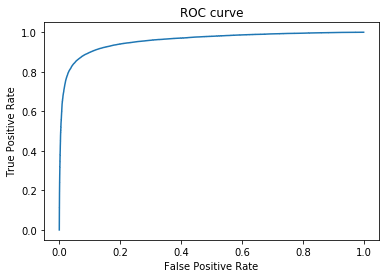

In [312]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_trainval_binary==1, y_pred_proba_bi)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [313]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99941604, 0.9994593 ,
       1.        ])

In [314]:
tpr

array([0.00000000e+00, 2.73194186e-05, 2.75926128e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [315]:
dump(fpr, 'fpr2.joblib')

['fpr2.joblib']

In [316]:
dump(tpr, 'tpr2.joblib')

['tpr2.joblib']

In [ ]:
newdata = pd.DataFrame(fpr, tpr)

In [309]:
fpr = pd.DataFrame(data=fpr, columns=['fpr'])

In [310]:
tpr = pd.DataFrame(data=fpr, columns=['tpr'])

In [308]:
fprtpr = pd.concat([fpr,tpr])

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [305]:
fprtpr

,fpr,tpr
0,0.000000,NaN
1,0.000000,NaN
2,0.000000,NaN
3,0.000022,NaN
4,0.000022,NaN
5,0.000022,NaN
6,0.000022,NaN
7,0.000043,NaN
8,0.000043,NaN
9,0.000065,NaN


In [295]:
dump(fpr, 'fpr.joblib')

['fpr.joblib']

In [296]:
dump(tpr, 'tpr.joblib')

['tpr.joblib']

In [300]:
dump(fprtpr, 'fprtpr.joblib')

['fprtpr.joblib']